# Set up environment in notebook

## Install packages for Watson Studio

In [1]:
!pip install --upgrade "ibm-watson>=4.0.1"
!pip install --upgrade "dash>=1.2.0"
!pip install --upgrade "plotly>=4.1.1"
!rm -rf discover-archetype
!git clone -b refactor https://github.com/tonanhngo/discover-archetype.git

Requirement already up-to-date: ibm-watson>=4.0.1 in /opt/conda/envs/Python36/lib/python3.6/site-packages (4.1.0)
Requirement already up-to-date: dash>=1.2.0 in /opt/conda/envs/Python36/lib/python3.6/site-packages (1.7.0)
Requirement already up-to-date: plotly>=4.1.1 in /opt/conda/envs/Python36/lib/python3.6/site-packages (4.3.0)
Cloning into 'discover-archetype'...
remote: Enumerating objects: 204, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 204 (delta 107), reused 152 (delta 64), pack-reused 0
Receiving objects: 100% (204/204), 1.70 MiB | 0 bytes/s, done.
Resolving deltas: 100% (107/107), done.


## Configure parameters

In [2]:
import sys
sys.path.append("discover-archetype/python")
import find_archetype
from ibm_watson.natural_language_understanding_v1 import Features,CategoriesOptions,ConceptsOptions,EntitiesOptions,KeywordsOptions,RelationsOptions,SyntaxOptions

print('Credentials needed for https://cloud.ibm.com/catalog/services/natural-language-understanding )')

#NLU_APIKEY = input(prompt='Please enter the API-Key for your Watson NLU service:')
NLU_APIKEY = "FpLZIZDgOo4ESQJ-s8-Sn4yrjWQKAsNMIKose9K0ber3"
NLU_ENDPOINT = "https://gateway.watsonplatform.net/natural-language-understanding/api"

# If true, use the IBM Cloud Storage for input and output
# If false, use local file system
USE_CLOUD_STORE = True

# Configure the following if using IBM Object Cloud Storage
# This is needed for running your notebook on Watson Studio, but can also be used when running your notebook locally
PATH = {}
if USE_CLOUD_STORE:
    PATH['dictation_bucket'] = "dictations"
    PATH['nlu_bucket'] = "output-nlu"
    PATH['cos_dictation_apikey'] = "Lu30IkOSRK5g8Fw-PgsWurGEkDl4NpjRtgK6dptwd0JA"
    #PATH['cos_dictation_apikey'] = input(prompt='Please enter the API-Key for your dictation bucket in IBM Cloud Object Storage:')
    PATH['cos_dictation_crn'] = "crn:v1:bluemix:public:cloud-object-storage:global:a/0b5a00334eaf9eb9339d2ab48f2d4767:e6f2b348-2eef-48af-9abe-338bea538358:bucket:dictations"
    PATH['cos_dictation_endpoint'] = "https://s3.us-east.cloud-object-storage.appdomain.cloud"
    PATH['cos_dictation_auth_endpoint'] = "https://iam.cloud.ibm.com/identity/token"
    
    PATH['cos_nlu_apikey'] = "3iTnL3kfrDHqnHj15V_PRDpPOvGwh4LGrfPvAvmP0QCe"
    #PATH['cos_nlu_apikey'] = input(prompt='Please enter API-Key for your NLU bucket in IBM Cloud Object Storage:')
    PATH['cos_nlu_crn'] = "crn:v1:bluemix:public:cloud-object-storage:global:a/0b5a00334eaf9eb9339d2ab48f2d4767:e6f2b348-2eef-48af-9abe-338bea538358:bucket:output-nlu"
    PATH['cos_nlu_endpoint'] = "https://s3.us-south.cloud-object-storage.appdomain.cloud"

else:
    # Where to load data from and save data to
    PATH['data']    = '../data/Documents/'
    PATH['results'] = './Watson-nlu-results/'

NLU = {}
NLU['apikey']         = NLU_APIKEY
NLU['apiurl']         = NLU_ENDPOINT
NLU['version']        = '2019-07-12'
NLU['features']       = Features(
                        categories= CategoriesOptions(),
                        concepts  = ConceptsOptions(),
                        entities  = EntitiesOptions(),
                        keywords  = KeywordsOptions(),
                        relations = RelationsOptions(),
                        syntax    = SyntaxOptions()
                        )


Credentials needed for https://cloud.ibm.com/catalog/services/natural-language-understanding )


# EXPLORING ARCHETYPES

When exploring the dimensionality of the problem we used SVD - the 'singular value decomposition' of a matrix of data. Now we move on to Archetypal analysis, a type of 'soft clustering'. 

The relationship between SVD and Archetypes/Cluster representations is not unlike the relation between waves and particles, where SVD is more like an overlay of multiple waves, like jpeg uses the fourier/cosine transform to decompose pictures, while Archetypes/Clusters are more like representing the picture as a sum of objects. The dimensionality distribution in SVD is not unlike the frequency distribution in a jpeg, although much less restricted. Fourier/Cosine transform has its basis functions predefined and has to stick to its delocalized functions, while SVD is more flexible in its choice of basis functions. The don't have to be delocalized, even if they often are. In fact, the clustering/Archetypal analysis trades information quality in return for intuitive interpretability. It is easier to understand a sum of objects than an overlay of waves. The key difference is that waves have phase, they have both negative and positive amplitude. Objects, on the other hand, never have negative presence - the presence of objects always add up, they can't cancel each other out like waves do. This explains the name of the method we use for computing the Archetypes/Clusters: "Non-Negative Matrix Factorization" (NMF). SVD factorizes a matrix into orthogonal components that can have either negative of positive matrix elements. NMF requires that all matrix elements are positive. NMF does, however, still allow delocalization. In straightforward clustering models, an element belongs to one or the other cluster. NMF is an example of "soft clustering" where an element can belong to several clusters, just like a word can belong to several overlapping categories. 

Since NMF has more restrictions than SVD, we assume that SVD is a lower limit for the dimensionality reduction that can be achieved through NMF. According to the same line of reasoning, the overlap between two different Archetypes/Soft Clusters can't be smaller than zero. The overlap between two different modes of 'waves' in SVD will always be zero. 

With this in mind we now identify the Archetypes of our corpus of dictations by computing the NMF-clusters. 

Here below we choose to partition our corpus into six archetypes. 

In [3]:
## INSTANTIATE THE WatsonDocumentArchetypes OBJECT as 'wda' 
# Split dictations into train/test-set with 5% set aside as test-dictations
wda    = find_archetype.WatsonDocumentArchetypes(PATH,NLU,train_test = 0.05, random_state = 42, use_cloud_store = USE_CLOUD_STORE)

# wda_a has no test-dictations, all are included in the corpus.
#wda_a  = find_archetype.WatsonDocumentArchetypes(PATH,NLU,train_test = False, use_cloud_store = USE_CLOUD_STORE)

# BUILDING THE ARCHETYPES


In the plots below the different archetypes are shown and compared. Each plot is organized so that one (key) archetype is plotted in order from its largest variable and downwards. The other archetypes' values for the same components are shown for comparison. 

The list is truncated where the key archetype's component values go below 10% of the strongest component. 

## 1. FROM ENTITIES

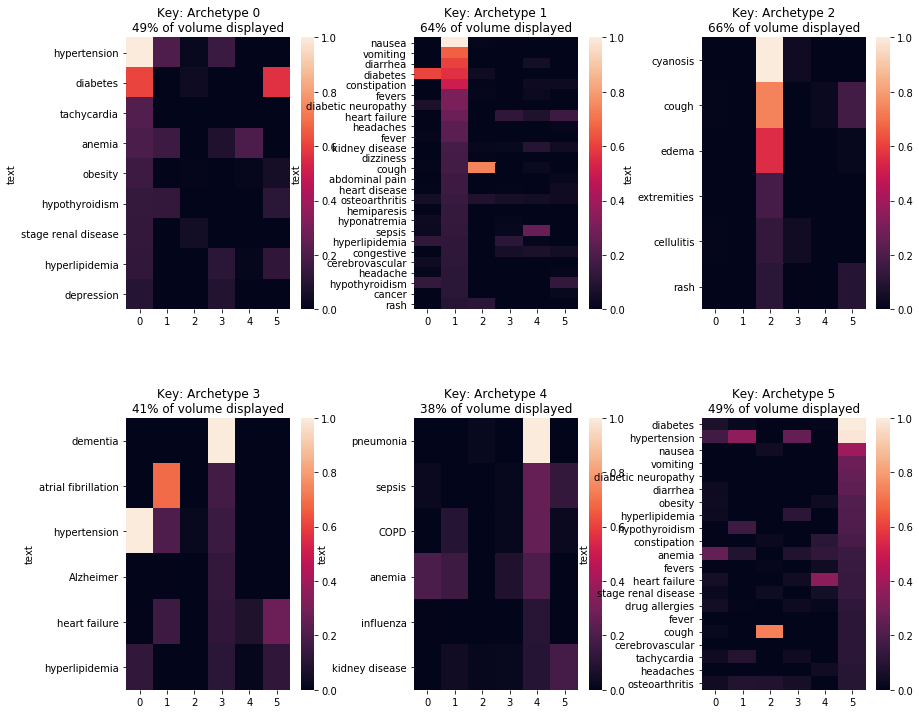

In [4]:
import show_archetype
fig = show_archetype.plot_archetypes(wda, 'entities')
fig.show()

## 2. FROM CONCEPTS

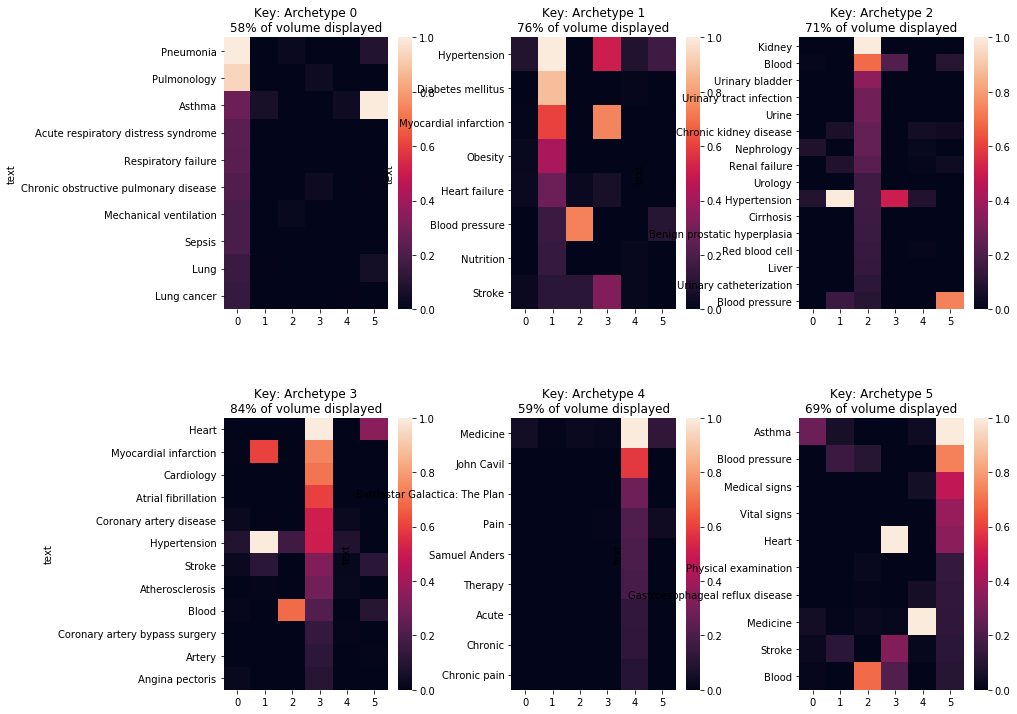

In [5]:
fig = show_archetype.plot_archetypes(wda, 'concepts')
fig.show()

## 3. FROM KEYWORDS


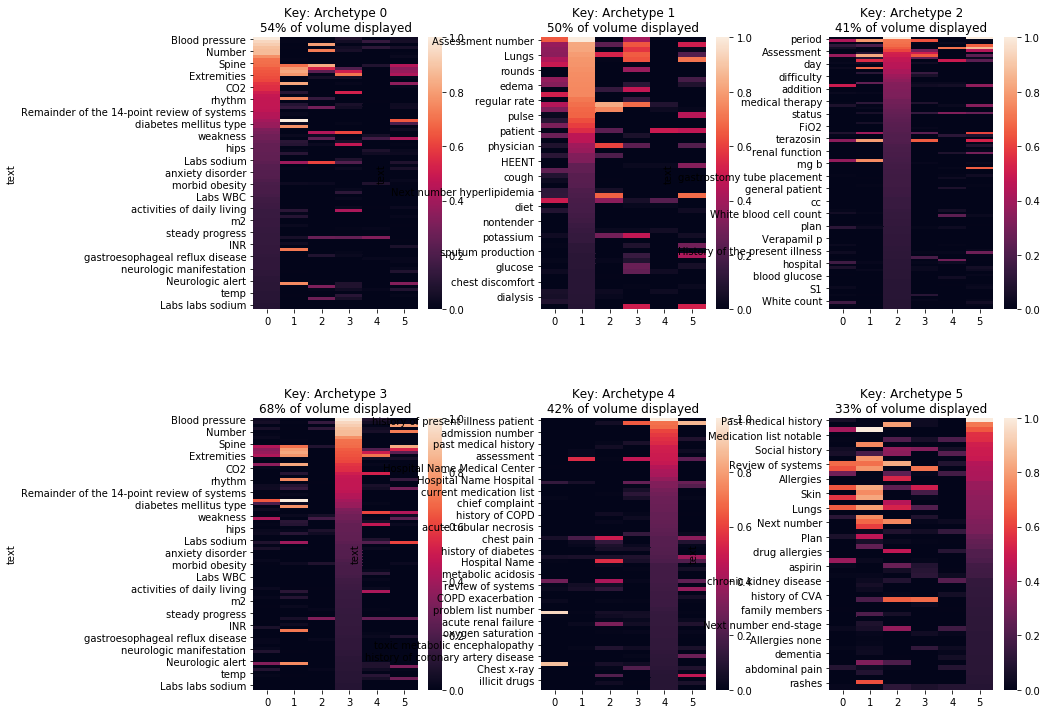

In [6]:
fig = show_archetype.plot_archetypes(wda, 'keywords')
fig.show()

# USING THE ARCHETYPES AS A COORDINATE SYSTEM FOR DOCUMENTS

We apply hierarchical clustering (dendrograms) to organize the dictations so that the clustering ones are put next to each other. We see that they are quite distinct. 

The columns represent the six archetypes, the rows are the dictations. 

The dictations are normalized so that the sum of coefficients over the archetypes sum up to exactly one for each dictation. A row with a completely white segment will therefore be completely black otherwise, indicating that 100% of he dictation belongs to the 'white' archetype. 

## ENTITY-ARCHETYPES

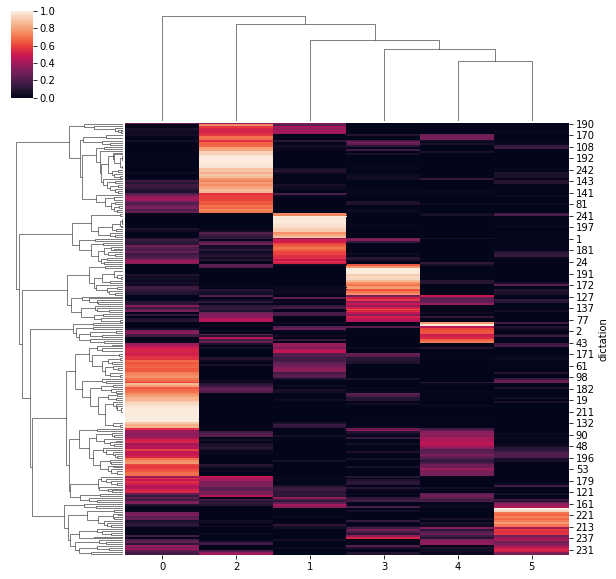

In [7]:
## ARCHETYPES based on ENTITIES in corpus texts
show_archetype.plot_coordinate(wda, "entities")

## CONCEPT - ARCHETYPES

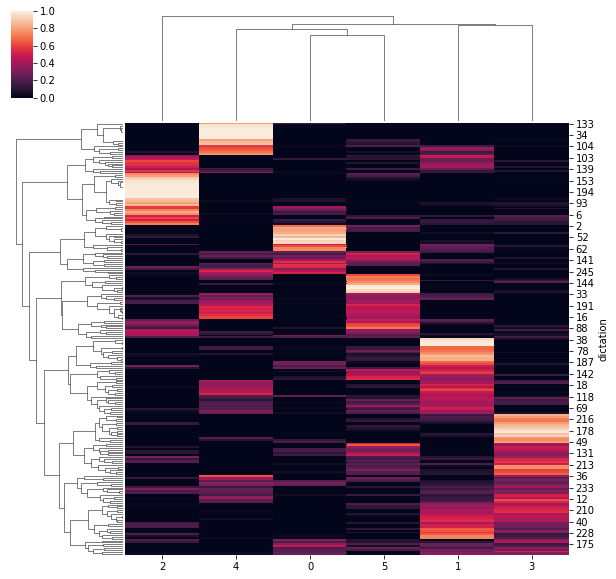

In [8]:
## ARCHETYPES based on CONCEPTS in corpus texts
show_archetype.plot_coordinate(wda,'concepts')

## KEYWORD-ARCHETYPES 

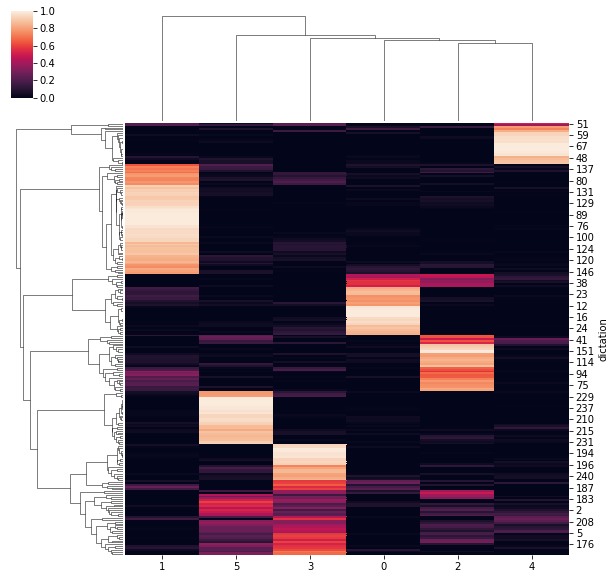

In [9]:
## ARCHETYPES based on KEYWORDS in corpus texts
show_archetype.plot_coordinate(wda,'keywords')

# ANALYZING NEW DOCUMENTS 

**SCENARIO**: 
1. A physician dictates notes after examining a patient. 
2. The dictation is automatically transcribed. 
3. The dictation (transcript) is analyzed by Watson NLU, returning entities/concepts/keywords as shown above.
4. The analysis is mapped onto the archetypes shown above and returned to the physician. 

Note that we do not include the new document in the corpus.

Here we will go through steps 3-4, assuming that 1-2 have already been performed. 

## 2. Analyzing a New Transcript

We emulate a new transcript by picking one from our test set. Not included in the corpus. 



In [10]:
## We emulate a new transcript by picking one from our test set. Not included in the corpus. 

test_name = wda.names_test[1]

test_text = wda.dictation_df.loc[test_name]
test_text



'_________is seen today on rounds. I was called earlier today to state that he had an MBS which is recommended NPO status. I did meet with family today and have asked them to decide for whether they would like to proceed with PEG tube placement or to sign a waiver. The patient appears comfortable during my exam. Later approximately an hour later, he would show signs and symptoms of respiratory distress and would be sent to the emergency room. The patient had denied shortness of breath prior. Physical exam vital signs blood pressure 120/81, pulse 75, respirations 20. HEENT  no JVD noted. Heart irregularly regular. Lungs no wheezes or rhonchi are noted. Abdomen soft, nondistended, nontender with positive bowel sounds x4. Extremities trace edema noted pretibially. Skin no rashes noted. Assessment number one dysphagia with recommendation for NPO status. Next number Parkinsonism. Next number pulmonary embolism, on Coumadin. Next number hypertension. Next number atrial fibrillation. Next num

## 3. RUN WATSON NLU ON TEST DOCUMENT

In [11]:
## DAVID TO TEAM: See self.watson and self.watson_nlu - which does the Watson analysis 
## for all documents in the corups. Reuse code?.



# ## Call Watson API
# def watson_nlu(text, 
#                typ_list = ['entities','concepts','keywords']):
#     module = wda.nlu_model.analyze(text = text, features=NLU['features'])
#     result = {}
#     for typ in typ_list:
#          result[typ] = pd.DataFrame(module.result[typ])
#     return result

# test_watson = watson_nlu(test_text)

test_watson = wda.watson_nlu[test_name]
test_watson
    

{'usage':                  0
 0       text_units
 1  text_characters
 2         features,
 'relations':                                            arguments     score  \
 0  [{'text': 'I', 'location': [34, 35], 'entities...  0.886722   
 1  [{'text': 'earlier today', 'location': [47, 60...  0.902384   
 2  [{'text': 'state', 'location': [64, 69], 'enti...  0.764492   
 3  [{'text': 'I', 'location': [122, 123], 'entiti...  0.591940   
 4  [{'text': 'them', 'location': [166, 170], 'ent...  0.911102   
 5  [{'text': 'he', 'location': [348, 350], 'entit...  0.719491   
 
                                             sentence          type  
 0  I was called earlier today to state that he ha...       agentOf  
 1  I was called earlier today to state that he ha...        timeOf  
 2  I was called earlier today to state that he ha...    affectedBy  
 3  I did meet with family today and have asked th...       agentOf  
 4  I did meet with family today and have asked th...    affectedBy  
 5  La

In [12]:
test_watson['concepts']

,dbpedia_resource,relevance,text
0,http://dbpedia.org/resource/Heart,0.962796,Heart
1,http://dbpedia.org/resource/Pulmonary_embolism,0.923361,Pulmonary embolism
2,http://dbpedia.org/resource/Stroke,0.920210,Stroke
3,http://dbpedia.org/resource/Pulmonology,0.903813,Pulmonology
4,http://dbpedia.org/resource/Atrial_fibrillation,0.851843,Atrial fibrillation
5,http://dbpedia.org/resource/Heart_failure,0.798471,Heart failure
6,http://dbpedia.org/resource/Asthma,0.754193,Asthma
7,http://dbpedia.org/resource/Pulmonary_edema,0.746125,Pulmonary edema


In [13]:
## Construct the 'concepts'-word vector

test_vec = test_watson['concepts'].set_index('text')[['relevance']].apply(find_archetype.norm_dot)
test_vec

,relevance
text,
Heart,0.395308
Pulmonary embolism,0.379117
Stroke,0.377823
Pulmonology,0.371091
Atrial fibrillation,0.349753
Heart failure,0.327839
Asthma,0.309659
Pulmonary edema,0.306347


## 4. MAP TEST DOCUMENT ON ARCHETYPES 

### 1:  Similarities to Archetypes

We project the test document onto the Archetypes by using **cosine similarities** showing 'how similar' the document is to an archetype. The similarity between an archetype vector **a** and the test document vector **d** is 

$$\text{similarity} = {\mathbf{a} \cdot \mathbf{d} \over \|\mathbf{a}\| \|\mathbf{d}\|}= \mathbf{\widehat{a}} \cdot \mathbf{\widehat{d}} $$

where the 'hat' represents 'dot-normalized' vectors, such that $ \mathbf{\widehat{a}} \cdot \mathbf{\widehat{a} = 1}$

**NOTE** that, since the Archetypes are NOT an orthogonal set, projecting the test document onto the Archetypes, i.e. saying 'the test document is this much similar to the first archetype and that much similar to the second archetype' is *NOT* the same as saying 'the test vector can be described as a sum of this much of the first archetype and that much of the second archetype. Because the archetypes have overlap, the overlapping similarities will be erroneously amplified, multiplied by the summation. Consider: A mule is half horse and half donkey. A mule on a hill is half a horse on a hill and half a donkey on a hill, but don't sum that up to a half a horse and half a donkey on *two* hills. When using Archetypes as a basis set, this will be taken into account. We do this in "Archetypes as a basis set"

Here we will only look at the **projections / similarities** between a document and the archetypes. 

In [14]:
archetypes = wda.archetypes(typ='concepts',n_archs=6)

In [15]:
archetypes.f

text,2,Abdominal pain,Abnormal psychology,Acinetobacter,Acromion,Acupuncture,Acute,Acute respiratory distress syndrome,Addiction,Alcoholic liver disease,...,Ventricle,Vital signs,Vitamin D,Vomiting,Vulva,Warfarin,West Nile virus,White blood cell,Wrist,Zenker's diverticulum
0,0.000000,0.000000,0.000000,0.14647,0.000092,0.000000,0.000000,0.656568,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027203,0.000000,0.000000
1,0.000000,0.030746,0.000000,0.00288,0.000000,0.022257,0.000000,0.000000,0.008732,0.008343,...,0.000000,0.00000,0.082340,0.047953,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.065050,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.031752,0.030341,...,0.000426,0.00000,0.017877,0.000000,0.000000,0.000000,0.048128,0.054780,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.00000,0.000137,0.034313,0.000000,0.000000,0.000000,0.000000,...,0.034511,0.00000,0.026997,0.000000,0.000000,0.030577,0.000000,0.007808,0.000000,0.032178
4,0.052237,0.011489,0.019684,0.00000,0.000033,0.034299,0.425674,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.065370,0.000000,0.005225,0.000000,0.000000,0.000000,0.000500,0.000000
5,0.004116,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002095,1.02649,0.106650,0.039629,0.000000,0.000000,0.000000,0.000103,0.000466,0.013746


In [16]:
## Select the subset of features in corpus that cover the test vector.
in_common     = list(set(test_vec.index).intersection(set(archetypes.fn.columns)))

## Check if the test vector contains new features that are not in corpus
beyond_corpus = list(set(test_vec.index) - set(archetypes.fn.columns))

## Display
in_common, beyond_corpus

(['Heart failure',
  'Asthma',
  'Pulmonary edema',
  'Pulmonary embolism',
  'Atrial fibrillation',
  'Heart',
  'Stroke',
  'Pulmonology'],
 [])

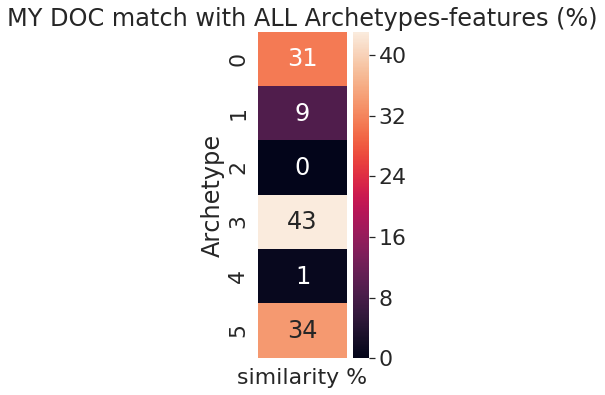

In [17]:
# Measure the similarities between the test vector and the archetypes
show_archetype.plot_similarity(((archetypes.fn[in_common] @ test_vec) * 100).applymap(int), 
                               'MY DOC match with ALL Archetypes-features (%)')

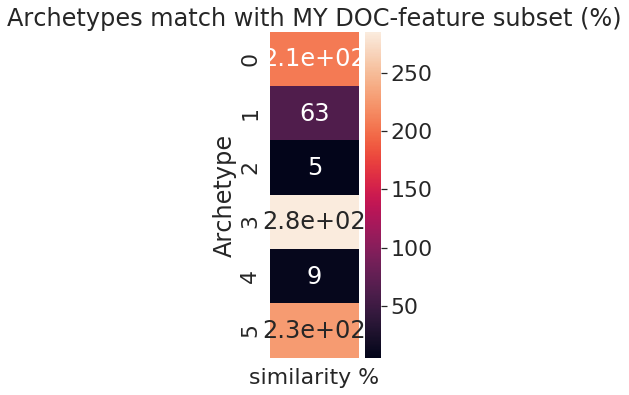

In [18]:
import numpy as np
scale_segment = np.sqrt(archetypes.fn.shape[1]/len(test_vec))
show_archetype.plot_similarity(((archetypes.fn[in_common]* scale_segment @ test_vec) * 100).applymap(int), 
                               'Archetypes match with MY DOC-feature subset (%)')

Text(0.5, 1.0, 'Match with Archetypes')

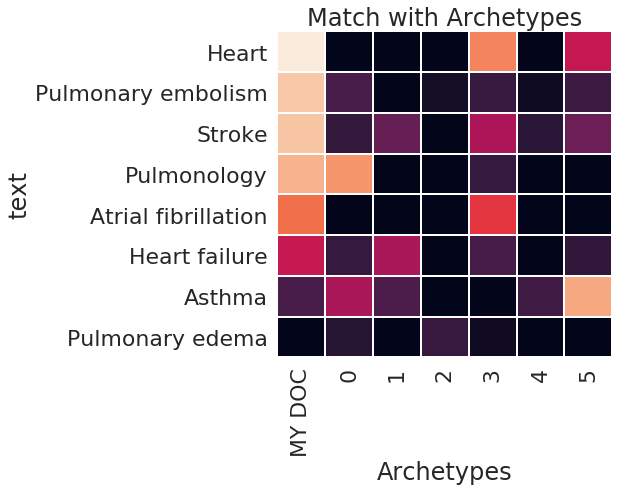

In [19]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale = 2)
compare = archetypes.fn[in_common].T
# mx = np.sqrt(archetypes.fn.shape[1]/len(test_vec))
mx = 1
compare = compare * mx
compare['MY DOC'] = test_vec.loc[in_common].apply(find_archetype.scale)
compare = compare.sort_values(by='MY DOC', ascending = False)[['MY DOC']+list(compare.columns)[:-1]]
plt.figure(figsize = (6,6))
sns.heatmap((compare*100).applymap(np.sqrt),linewidths = 1,cbar=False)
plt.xlabel('Archetypes')
plt.title('Match with Archetypes')

In [20]:
import pandas as pd
test_vec_expanded = pd.DataFrame(test_vec, index = archetypes.f.columns).apply(find_archetype.scale).fillna(-0.1)
test_vec_expanded.min()

relevance   -0.1
dtype: float64

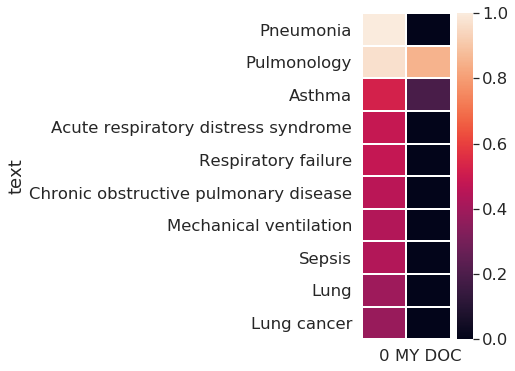

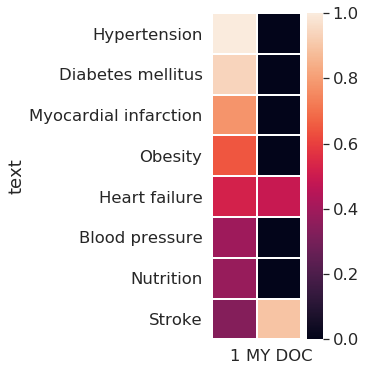

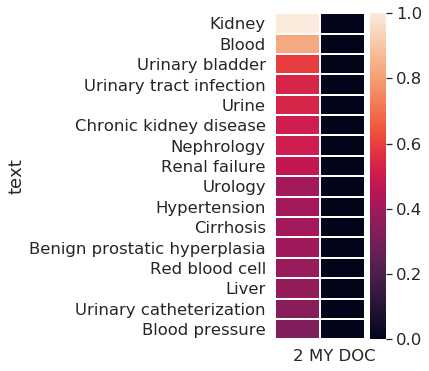

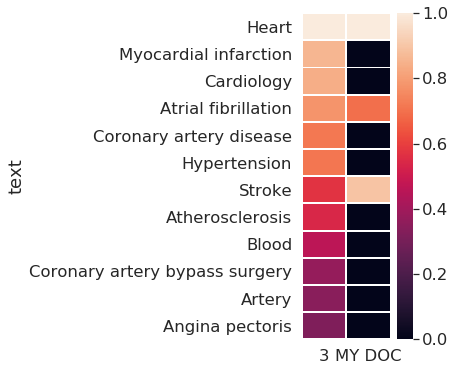

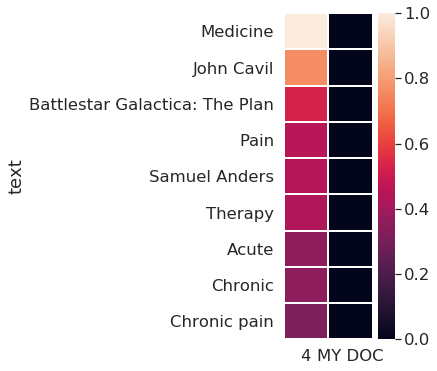

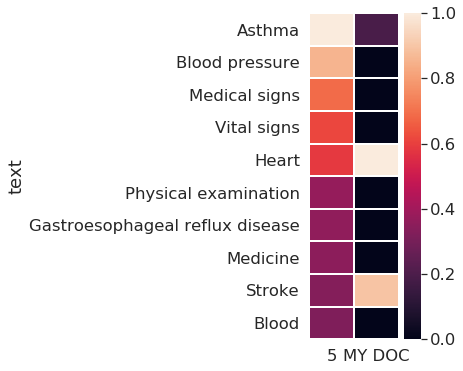

In [21]:
test_vec_expanded = pd.DataFrame(test_vec, index = archetypes.f.columns).apply(find_archetype.scale).fillna(0)

sns.set(font_scale = 1.5)
compare = archetypes.f.T.apply(find_archetype.scale)
compare['MY DOC'] = test_vec_expanded.apply(find_archetype.scale)
for ix in archetypes.f.index:
    cmp = compare.sort_values(by=ix,ascending=False)[[ix,'MY DOC']]
    cmp = cmp[cmp[ix] >0.1]
    plt.figure(figsize = (2,6))
    sns.heatmap(cmp.applymap(np.sqrt),linewidth = 1)
    plt.show()

# Dimensionality: How diverse is the corpus?

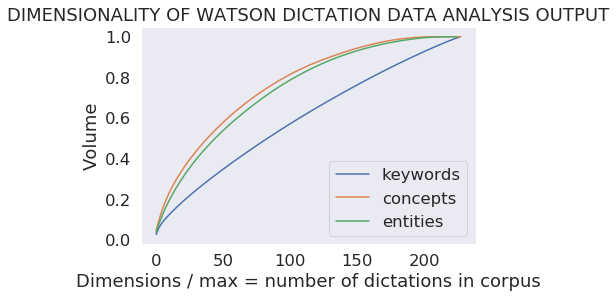

In [22]:
## David to team: as an extr feature, we can consider including the dimensionality analyis - the plot - as a feature for analysis.

## DIMENSIONALITY OF THE CORPUS
# Establish with Singular Value Decomposition (principal component analysis) :

types = ['keywords','concepts','entities']
svde  = {}
volume = {}
volume_distribution = {}

for typ in types:
    svde[typ]     = find_archetype.Svd(wda.X_matrix(typ))
    volume[typ] = svde[typ].s.sum()
    volume_distribution[typ] = svde[typ].s.cumsum()/volume[typ]
    plt.plot(volume_distribution[typ],label = typ)
plt.title('DIMENSIONALITY OF WATSON DICTATION DATA ANALYSIS OUTPUT')
plt.xlabel('Dimensions / max = number of dictations in corpus')
plt.ylabel('Volume')
plt.legend()
plt.grid()
plt.show()

## COMMENT: CONCEPTS AND ENTITIES OFFER A GREATER REDUCTION OF DIMENSIONALITY = THE MODELS FIT THE DATA BETTER (?)
## ? => WE ARE MEASURING THE WATSON OUTPUT ONLY. WE DON'T KNOW WHAT IS GOING ON INSIDE WATSON. 

## CONCLUSIONS: 
## DICTATION WORD/ENTITY/CONCEPTUAL CONTENT IS DIVERSE AND SPREAD OVER MANY DIMENSIONS
## ACCESS TO A LARGER CORPUS SHOULD BE VERY GOOD!

### COMMENT: 

CONCEPTS AND ENTITIES OFFER A GREATER REDUCTION OF DIMENSIONALITY = THE MODELS FIT THE DATA BETTER (?)

? => WE ARE MEASURING THE WATSON OUTPUT ONLY. WE DON'T KNOW WHAT IS GOING ON INSIDE WATSON. 

### DIMENSIONALITY - CONCLUSIONS: 
- IN OUR EXISTING CORPUS, THE DICTATION WORD/ENTITY/CONCEPTUAL CONTENT IS DIVERSE AND SPREADS ACROSS MANY DIMENSIONS
- ACCESS TO A LARGER CORPUS SHOULD BE VERY GOOD!